# Notebook 3 - Model baseline

### 1. Setup constants

In [1]:
from constants import *

### 2. Imports and notebook setup

In [2]:
# Set up multiple outputs for cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Printing with markdown
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Default imports
import os
import random
import shutil
from glob import glob
from send2trash import send2trash
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sn

### 3. Read data

In [4]:
file_rgb = 'hmnist_28_28_RGB.csv'
file_gray = 'hmnist_28_28_L.csv'
file_reference = 'HAM10000_metadata.csv'

In [5]:
df_rgb = pd.read_csv(os.path.join(DATA_ORIGINAL_DIR_PATH, file_rgb))
df_gray = pd.read_csv(os.path.join(DATA_ORIGINAL_DIR_PATH, file_gray))
df_ref = pd.read_csv(os.path.join(DATA_ORIGINAL_DIR_PATH, file_reference))

In [6]:
df_rgb.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [7]:
df_rgb.label.value_counts()
df_ref.dx.value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [8]:
df_ref.dx.value_counts() / len(df_ref)

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

### 4. Modify target to binary

In [9]:
df_ref['dx'] = df_ref['dx'].apply(lambda x: 'other' if x != 'mel' else 'mel')

### 5. Train test split

In [10]:
# Setting random seed for the split
random.seed(100)

# We're splitting on lesion_id to avoid data leakage
test_rate = 0.25
lesions = df_ref.lesion_id.unique().tolist()
test_size = round(test_rate * len(lesions))

test_lesions = random.sample(population=lesions, k=test_size)
test_indices = df_ref[df_ref.lesion_id.isin(test_lesions)].index
train_indices = df_ref[~df_ref.lesion_id.isin(test_lesions)].index

In [11]:
df_rgb_train = df_rgb.iloc[train_indices, :]
df_rgb_test = df_rgb.iloc[test_indices, :]

df_gray_train = df_gray.iloc[train_indices, :]
df_gray_test = df_gray.iloc[test_indices, :]

In [13]:
print('Train:', len(df_rgb_train), 'Test:', len(df_rgb_test),
      'Proportion:', len(df_rgb_train)/ (len(df_rgb_train) + len(df_rgb_test)))

print('Train:', len(df_gray_train), 'Test:', len(df_gray_test),
      'Proportion:', len(df_gray_train)/ (len(df_gray_train) + len(df_gray_test)))

Train: 7529 Test: 2486 Proportion: 0.7517723414877684
Train: 7529 Test: 2486 Proportion: 0.7517723414877684


In [12]:
# RGB
X_rgb_train = df_rgb_train.drop('label', axis=1)
y_rgb_train = df_rgb_train['label'].apply(lambda x: 1 if x == DIAG_2_NUM['mel'] else 0)

X_rgb_test = df_rgb_test.drop('label', axis=1)
y_rgb_test = df_rgb_test['label'].apply(lambda x: 1 if x == DIAG_2_NUM['mel'] else 0)

# GRAY
X_gray_train = df_gray_train.drop('label', axis=1)
y_gray_train = df_gray_train['label'].apply(lambda x: 1 if x == DIAG_2_NUM['mel'] else 0)

X_gray_test = df_gray_test.drop('label', axis=1)
y_gray_test = df_gray_test['label'].apply(lambda x: 1 if x == DIAG_2_NUM['mel'] else 0)

### 7. Fit models

In [13]:
np.set_printoptions(precision=2)
# # Plot non-normalized confusion matrix
# _ = plot_confusion_matrix(y_true=y_rgb_test, y_pred=predictions, classes=np.array(names),
#                       title='Confusion matrix, without normalization')
# # Plot normalized confusion matrix
# _ = plot_confusion_matrix(y_true=y_rgb_test, y_pred=predictions, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
# plt.show()

#### 7.1 KNN - RGB

In [33]:
for n_neighbors in range(46, 50):
    knn_reg = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)
    _ = knn_reg.fit(X_rgb_train, y_rgb_train)
    predictions = knn_reg.predict(X_rgb_test)
    print('n_neighbors:', n_neighbors, 'AUC:', roc_auc_score(y_true=y_rgb_test, y_score=predictions))

n_neighbors: 46 AUC: 0.7804721206359106
n_neighbors: 47 AUC: 0.7816207306501133
n_neighbors: 48 AUC: 0.7799422509067313
n_neighbors: 49 AUC: 0.7796915688671351


In [34]:
knn_reg = KNeighborsRegressor(n_neighbors=44, n_jobs=-1)
_ = knn_reg.fit(X_rgb_train, y_rgb_train)
predictions = knn_reg.predict(X_rgb_test)
roc_auc_score(y_true=y_rgb_test, y_score=predictions)

0.7823610391483182

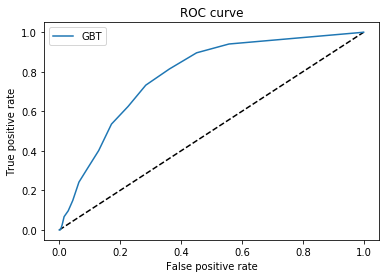

In [35]:
fpr, tpr, _ = roc_curve(y_true=y_rgb_test, y_score=predictions)

_ = plt.figure(1)
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr, label='GBT')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
_ = plt.title('ROC curve')
_ = plt.legend(loc='best')
plt.show()


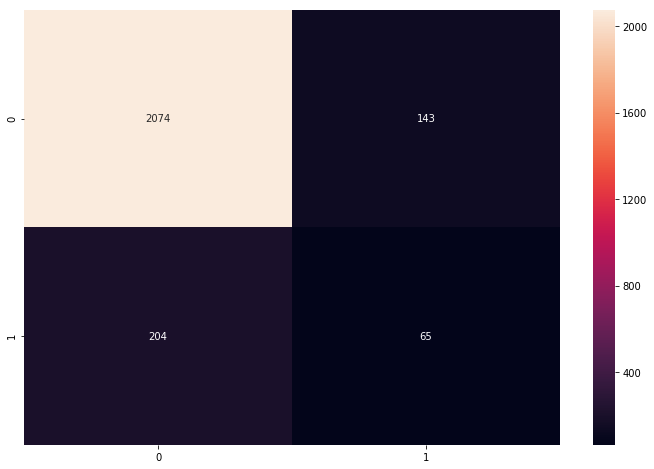

In [36]:
threshold = .2
cm = confusion_matrix(y_true=y_rgb_test, y_pred=np.array(predictions > threshold, dtype=np.int16))
df_cm = pd.DataFrame(cm)
_ = plt.figure(figsize = (12, 8))
_ = sn.heatmap(df_cm, annot=True, fmt='d')

#### 7.2 KNN - Gray

In [40]:
for n_neighbors in range(56, 61):
    knn_reg = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)
    _ = knn_reg.fit(X_gray_train, y_gray_train)
    predictions = knn_reg.predict(X_gray_test)
    print('n_neighbors:', n_neighbors, 'AUC:', roc_auc_score(y_true=y_gray_test, y_score=predictions))

n_neighbors: 56 AUC: 0.7125607631465543
n_neighbors: 57 AUC: 0.7125272270877454
n_neighbors: 58 AUC: 0.714769951020586
n_neighbors: 59 AUC: 0.7161189389861714
n_neighbors: 60 AUC: 0.7151170492292576


In [43]:
knn_reg = KNeighborsRegressor(n_neighbors=42, n_jobs=-1)
_ = knn_reg.fit(X_gray_train, y_gray_train)
predictions = knn_reg.predict(X_gray_test)
roc_auc_score(y_true=y_gray_test, y_score=predictions)

0.7167125272270878

#### 7.3 Logistic Regression - RGB

In [80]:
lr_clf = LogisticRegression(n_jobs=-1, solver='lbfgs', class_weight='balanced')
_ = lr_clf.fit(X_rgb_train, y_rgb_train)
predictions = lr_clf.predict_proba(X_rgb_test)[:, 1]
roc_auc_score(y_true=y_rgb_test, y_score=predictions)

0.7214327275044309

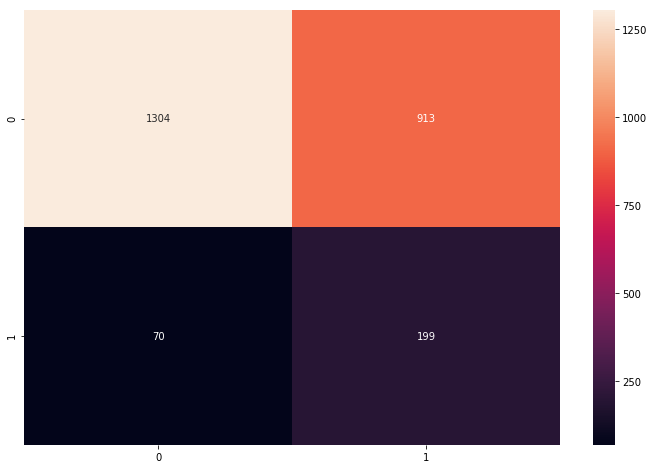

In [84]:
threshold = .3
cm = confusion_matrix(y_true=y_rgb_test, y_pred=np.array(predictions > threshold, dtype=np.int16))
df_cm = pd.DataFrame(cm)
_ = plt.figure(figsize = (12, 8))
_ = sn.heatmap(df_cm, annot=True, fmt='d')

#### 7.4 Logistic Regression - Gray

In [85]:
lr_clf = LogisticRegression(n_jobs=-1, solver='lbfgs', class_weight='balanced')
_ = lr_clf.fit(X_gray_train, y_gray_train)
predictions = lr_clf.predict_proba(X_gray_test)[:, 1]
roc_auc_score(y_true=y_gray_test, y_score=predictions)

0.6746767543131563

#### 7.5 Random Forest - RGB

In [68]:
np.set_printoptions(precision=4)

for n_estimators in [50, 100, 200, 500]:
    accs = []
    print('n_estimators:', n_estimators)
    for max_depth in [5, 10, 25, 50, 100, 150, 200, 300]:
        rf_clf = RandomForestClassifier(class_weight='balanced', n_estimators=n_estimators, 
                                        max_depth=max_depth, n_jobs=-1, random_state=42)
        _ = rf_clf.fit(X_rgb_train, y_rgb_train)
        predictions = rf_clf.predict_proba(X_rgb_test)[:, 1]
        accs.append(roc_auc_score(y_true=y_rgb_test, y_score=predictions))
    print(np.array(accs))

n_estimators: 50
[0.7652 0.7824 0.7884 0.7931 0.7926 0.7926 0.7926 0.7926]
n_estimators: 100
[0.7667 0.7832 0.8001 0.8022 0.8029 0.8029 0.8029 0.8029]
n_estimators: 200
[0.7678 0.7824 0.8003 0.8035 0.8031 0.8031 0.8031 0.8031]
n_estimators: 500
[0.7664 0.7818 0.8018 0.804  0.804  0.804  0.804  0.804 ]


In [69]:
rf_clf = RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=50, n_jobs=-1, random_state=42)
_ = rf_clf.fit(X_rgb_train, y_rgb_train)
predictions = rf_clf.predict_proba(X_rgb_test)[:, 1]
roc_auc_score(y_true=y_rgb_test, y_score=predictions)

0.8034728265699487

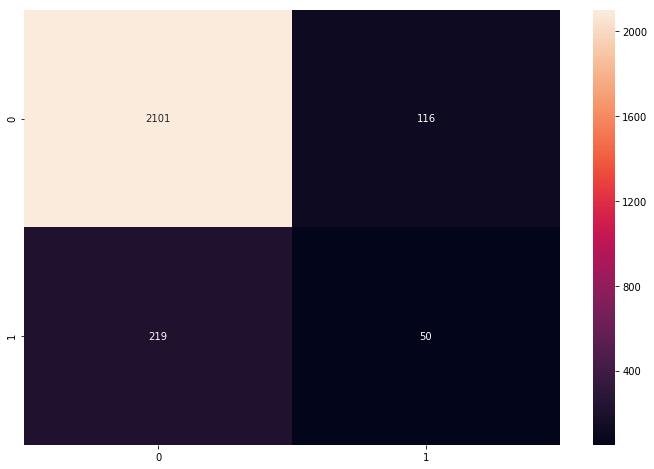

In [72]:
threshold = .3
cm = confusion_matrix(y_true=y_rgb_test, y_pred=np.array(predictions > threshold, dtype=np.int16))
df_cm = pd.DataFrame(cm)
_ = plt.figure(figsize = (12, 8))
_ = sn.heatmap(df_cm, annot=True, fmt='d')

#### 7.6 Random Forest - Gray

In [73]:
np.set_printoptions(precision=4)

for n_estimators in [50, 100, 200, 500]:
    accs = []
    print('n_estimators:', n_estimators)
    for max_depth in [5, 10, 25, 50, 100, 150, 200, 300]:
        rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
        _ = rf_clf.fit(X_gray_train, y_gray_train)
        predictions = rf_clf.predict_proba(X_gray_test)[:, 1]
        accs.append(roc_auc_score(y_true=y_rgb_test, y_score=predictions))
    print(np.array(accs))

n_estimators: 50
[0.7173 0.7386 0.7596 0.7669 0.7668 0.7668 0.7668 0.7668]
n_estimators: 100
[0.7184 0.7474 0.7653 0.7692 0.7692 0.7692 0.7692 0.7692]
n_estimators: 200
[0.7182 0.7477 0.7663 0.7662 0.7665 0.7665 0.7665 0.7665]
n_estimators: 500
[0.7186 0.7501 0.7647 0.7648 0.7649 0.7649 0.7649 0.7649]


In [75]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=-1, random_state=42)
rf_clf.fit(X_gray_train, y_gray_train)
_ = predictions = rf_clf.predict_proba(X_gray_test)[:, 1]
roc_auc_score(y_true=y_gray_test, y_score=predictions)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

0.7691981360658514